In [43]:
from py3lib import sarray
import numpy as np 
import pandas as pd
import sys
sys.path.append('/nas02/sap/ver/stable')  # stable是最新的稳定版本，也可以指定具体版本号例如 4.0.0
from sap.base import sapa_rust
import sap
sim = sap.newsim()
# 设定数据所在的目录, 设定之后, sim.diMax, sim.tiMax, sim.iiMax 就有值了。
sim.set_cachefolder('/local/trade/sapcache_1m_2020_prod/')
# 可选设定startdate与enddate, 如果不设定, 默认 sim.startdi=0, sim.enddi=sim.diMax-1, sim.update_ti_num=sim.diMax*sim.tiMax
sim.set_sim_date(20230101, 20250926)
print(sim.startdi, sim.enddi, sim.update_start_ti, sim.diMax, sim.tiMax, sim.iiMax, sim.update_ti_num)
self = sim
idx = pd.MultiIndex.from_product([self.Dates[sim.startdi:sim.enddi+1], np.array(self.tiTime)//1000], names=["date", "time"])
date_str = idx.get_level_values('date').astype(str)           # '20200102'
time_str = idx.get_level_values('time').astype(str).str.zfill(6)
datetime_idx = pd.to_datetime(date_str + time_str,
                              format='%Y%m%d%H%M%S')

idx_full = pd.MultiIndex.from_product([self.Dates, np.array(self.tiTime)//1000], names=["date", "time"])
date_str_full = idx_full.get_level_values('date').astype(str)           # '20200102'
time_str_full = idx_full.get_level_values('time').astype(str).str.zfill(
6)
datetime_idx_full = pd.to_datetime(date_str_full + time_str_full,
                              format='%Y%m%d%H%M%S')


[INFO  2025-11-15 13:24:45.987709 yjhuang] set sim date 20230103(startdi=728) to 20250926(enddi=1392)
728 1392 0 1393 240 5500 159600


In [ ]:
univ_tradable = sarray.load('/local/yjhuang/mysapcache/univ_daily_valid/valid.bin').data
univ_tradable.shape

(2857, 5500)

In [45]:
tradedate = pd.read_csv('/nas02/tradedates.txt',skiprows=[1])
tradedate_list =tradedate[(tradedate['TradingDate']>=20140101) & (tradedate['TradingDate']<=20250926)]['TradingDate'].to_list()

In [46]:
from py3lib import sarray

preds_full = sarray.load('/local/yjhuang/qlib_data/preds/preds_full.bin').data
preds_full.shape

(2857, 5500)

In [47]:
new_preds  = np.full((preds_full.shape[0], self.iiMax), np.nan, dtype=float)
new_preds[:,:preds_full.shape[1]] = preds_full

In [ ]:
y_returns = sarray.load('/local/yjhuang/mysapcache/labels/v2v_ret_5d.bin', copy_on_write=True).data
y_returns = y_returns - 0.001
df_preds = pd.DataFrame(new_preds, index=tradedate_list,columns=self.instruments)
df_returns = pd.DataFrame(y_returns, index=tradedate_list,columns=self.instruments)
y_returns[~univ_tradable] = np.nan

In [49]:
df_preds_rolling5 = df_preds.rolling(5).mean()
df_preds_rolling5_std = df_preds.rolling(5).std()

<Axes: >

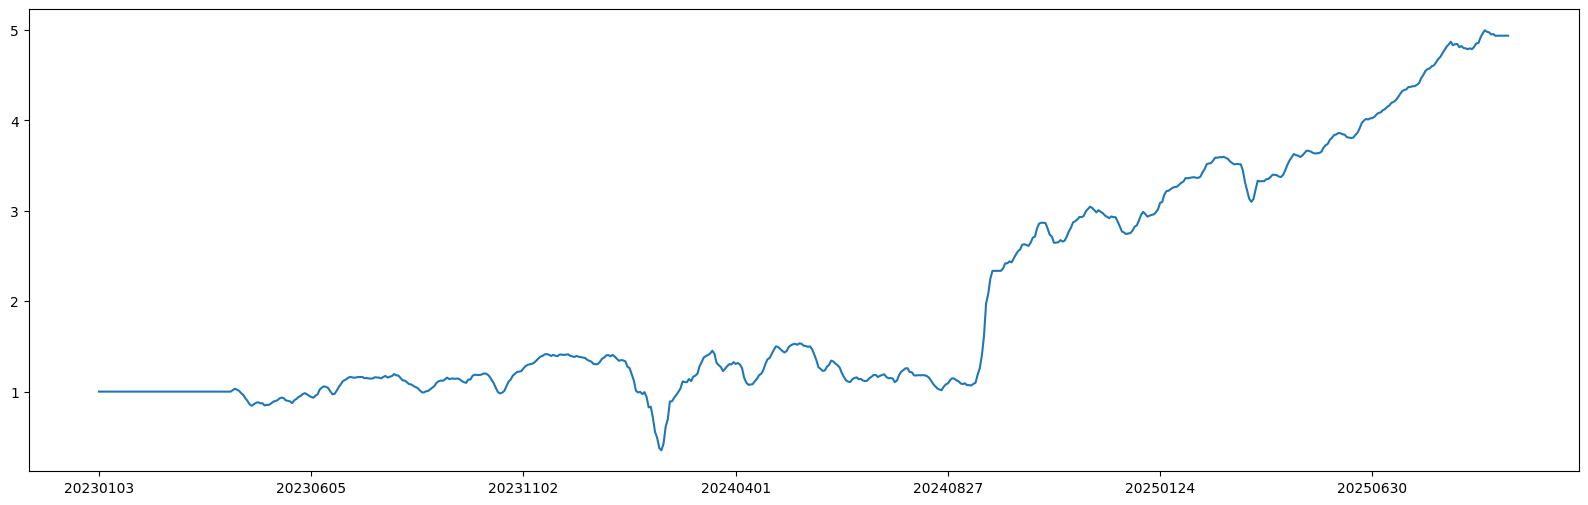

In [50]:
import pandas as pd
import numpy as np

# 假设 df_preds_rolling5 已经准备好了，index=交易日, columns=股票代码
preds = df_preds.copy()

# 1) 只要 >0 的才交易，其它直接视为不交易
mask =  (preds>df_preds_rolling5 + 1.5*df_preds_rolling5_std) & (preds>0)

# 2) 先把非交易的地方置 0，方便做行求和
positive_preds = preds.where(mask, 0.0)

# 3) 按行求和：得到每天所有“可交易股票”的预测值总和
row_sum = positive_preds.sum(axis=1)

# 4) 用每个股票的预测值 / 当天总和 = 权重
#    注意要对行做除法，要用 DataFrame.div
weights = positive_preds.div(row_sum, axis=0)

# 5) 把原来不交易的位置再变回 NaN 
weights = weights.where(mask, np.nan)

df_tmp = weights*df_returns

df_tmp.index = df_tmp.index.astype(str)
(df_tmp.loc['20230101':].sum(axis=1).cumsum()+1).plot(figsize=(20,6))

Annualized Return:  0.8313105030299957
Annualized Vol:     0.5764389735886007
Sharpe Ratio:       1.4421483298651738
Max Drawdown:       -0.7518189579653604
Calmar Ratio:       1.105732296615348


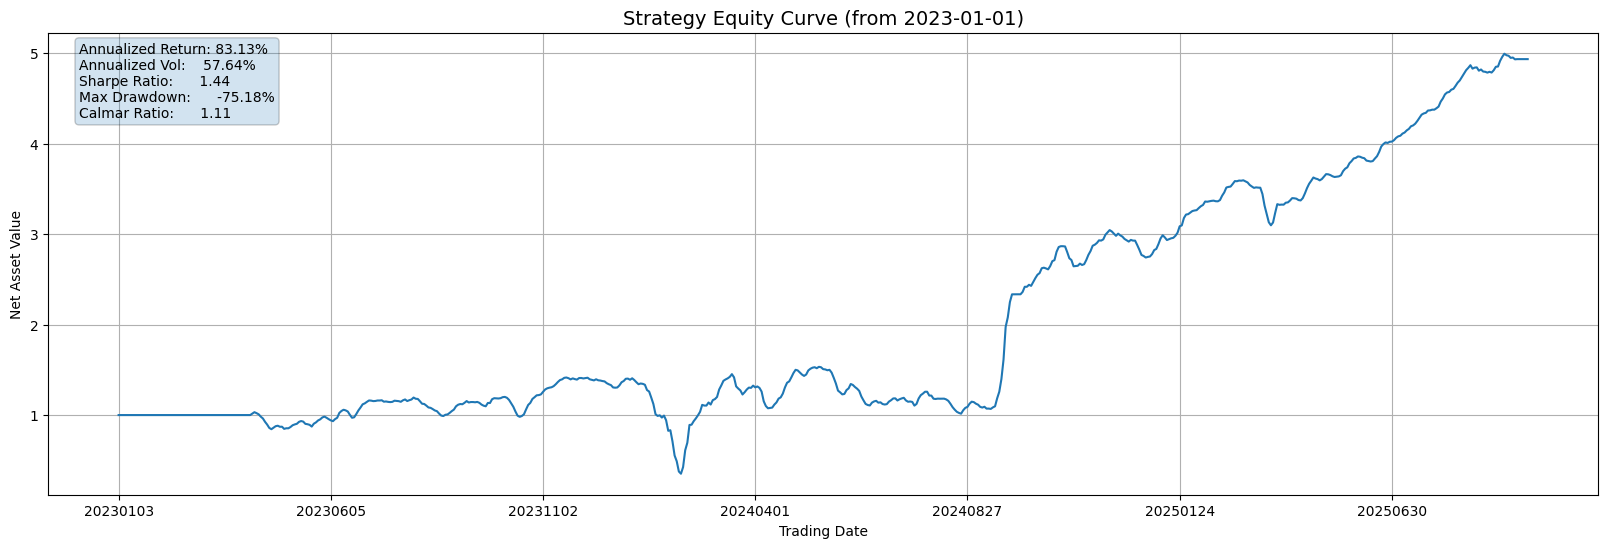

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Compute daily portfolio returns from df_tmp
# =========================
# Daily portfolio return = sum of all stock returns (weights already sum to 1 each day)
port_ret = df_tmp.loc['20230101':].sum(axis=1)   # Series, index = trading dates

# =========================
# Compute equity curve (simple interest / cumulative sum)
# =========================
equity_curve = port_ret.cumsum() + 1.0           # initial NAV = 1

# Number of trading days
n_days = len(port_ret)
trading_days_per_year = 252

# =========================
# Performance metrics
# =========================
# Annualized return
annual_return = equity_curve.iloc[-1]**(trading_days_per_year / n_days) - 1

# Annualized volatility
annual_vol = port_ret.std() * np.sqrt(trading_days_per_year)

# Sharpe ratio (risk-free rate = 0)
sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan

# Max drawdown
running_max = equity_curve.cummax()
drawdown = equity_curve / running_max - 1
max_drawdown = drawdown.min()   # e.g. -0.25 means -25%

# Calmar ratio (annual return / |max drawdown|)
calmar = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

print("Annualized Return: ", annual_return)
print("Annualized Vol:    ", annual_vol)
print("Sharpe Ratio:      ", sharpe)
print("Max Drawdown:      ", max_drawdown)
print("Calmar Ratio:      ", calmar)

# =========================
# Plot & annotate metrics
# =========================
fig, ax = plt.subplots(figsize=(20, 6))

equity_curve.plot(ax=ax)

ax.set_title("Strategy Equity Curve (from 2023-01-01)", fontsize=14)
ax.set_xlabel("Trading Date")
ax.set_ylabel("Net Asset Value")
ax.grid(True)

# Text box content
textstr = (
    f"Annualized Return: {annual_return:.2%}\n"
    f"Annualized Vol:    {annual_vol:.2%}\n"
    f"Sharpe Ratio:      {sharpe:.2f}\n"
    f"Max Drawdown:      {max_drawdown:.2%}\n"
    f"Calmar Ratio:      {calmar:.2f}"
)

# Put the text in the top-left corner of the plot
ax.text(
    0.02, 0.98, textstr,
    transform=ax.transAxes,
    va='top', ha='left',
    bbox=dict(boxstyle="round", alpha=0.2)
)

plt.show()


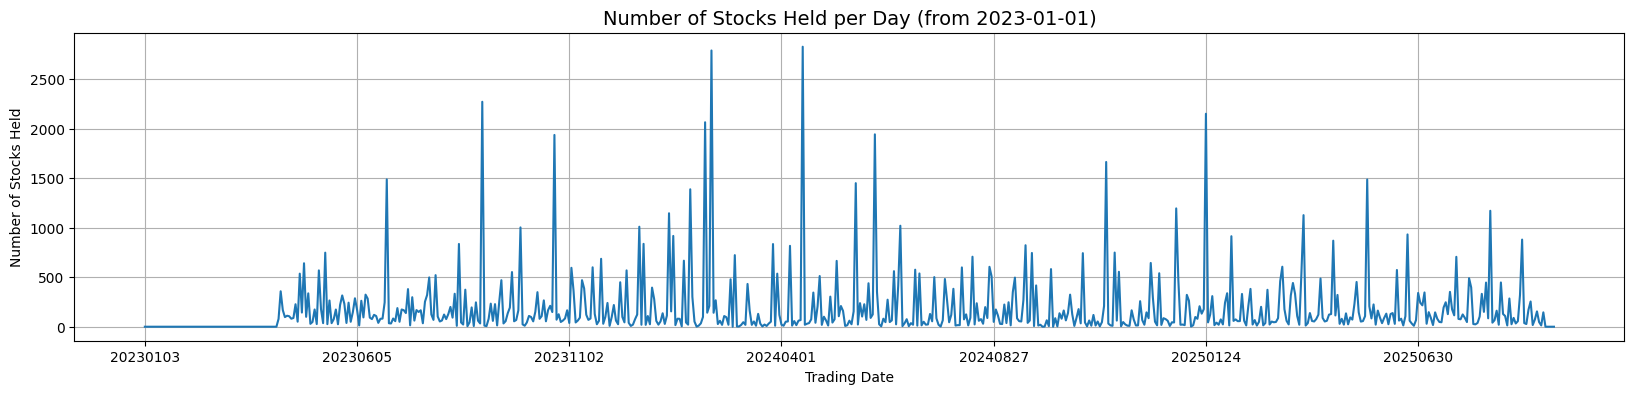

In [56]:
# =========================
# Number of holdings per day
# =========================
holding_counts = weights.loc['20230101':].notna().sum(axis=1)  # number of non-NaN per day
holding_counts.index = holding_counts.index.astype(str)
plt.figure(figsize=(20, 4))
holding_counts.plot()
plt.title("Number of Stocks Held per Day (from 2023-01-01)", fontsize=14)
plt.xlabel("Trading Date")
plt.ylabel("Number of Stocks Held")
plt.grid(True)
plt.show()
